## Introduction

First, you need to obtain and preprocess the data for the segmentation task
The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />
You can directly download the full body cts and segmentation maps from: <br />
https://drive.google.com/file/d/1I1LR7XjyEZ-VBQ-Xruh31V7xExMjlVvi/view?usp=sharing

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

## Imports
**Task: Import the necessary libraries**

In [1]:
!pip install pydicom

In [2]:
!pip install opencv-python

In [8]:
!pip install dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


In [21]:
%matplotlib notebook
from pathlib import Path
import torch
import pydicom
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
from torch.utils.data import Dataset
import nibabel as nib
from celluloid import Camera

## Inspection
**Task: Define the paths to images and labels**

In [22]:
root = Path("Task06_Lung/imagesTr")
label = Path("Task06_Lung/labelsTr")

**Task: Load a sample NIfTI and its corresponding label mask**<br />
Hint: You might want to define a helper function to make your life easier

In [23]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [24]:
sample_path = list(root.glob("lung*"))[2]
sample_path_label = change_img_to_label_path(sample_path)

In [25]:
sample_path, sample_path_label

(PosixPath('Task06_Lung/imagesTr/lung_041.nii.gz'),
 PosixPath('Task06_Lung/labelsTr/lung_041.nii.gz'))

In [26]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

**Task: Find out the orientation**

In [27]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

**Task: Inspect the loaded data with overlaid Ground Truth tumor segmentation**<br />
Hint: Use the axial view (last axis)<br />
You may skip every second slice to speed up the process


<IPython.core.display.Javascript object>


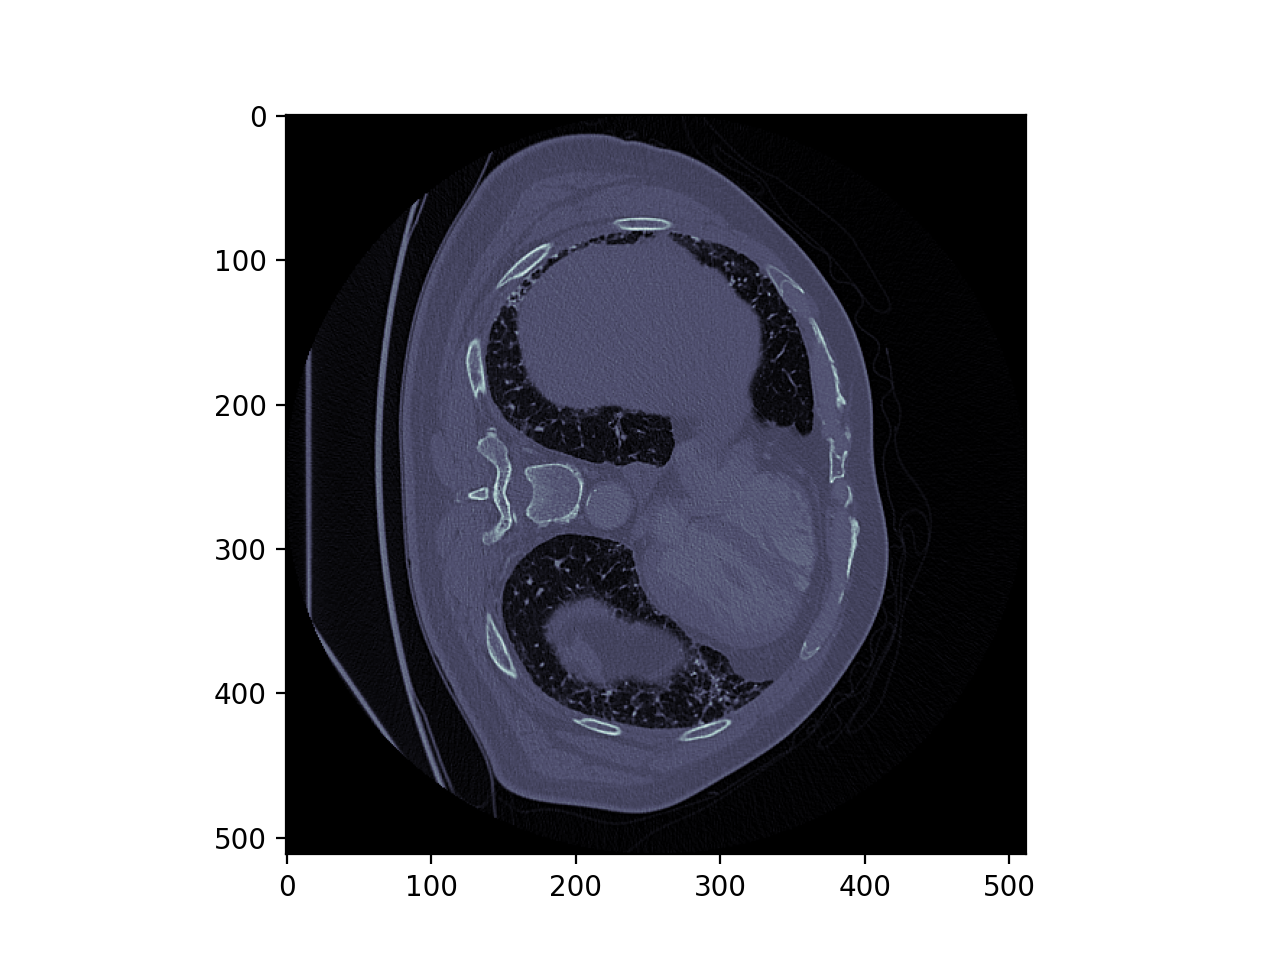

In [28]:
fig = plt.figure()
camera = Camera(fig)

for i in range (0, ct.shape[2], 2):
    plt.imshow(ct[:,:, i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    
    camera.snap()
animation = camera.animate()


In [30]:
from IPython.display import HTML
HTML(animation.to_html5_video())

In [ ]:
target_list = []
for _, label in train_dataset:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

In [ ]:
unique = np.unique(target_list, return_counts = True)
unique

In [ ]:
fraction = 12892/1437
fraction

In [ ]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [ ]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

In [ ]:
train_loader = torch.utils.data.Dataloader(train_loader, batch_size = 4, sampler = sampler)

In [ ]:
for data, label in train_loader:
    print(label.sum([1, 2, 3]))

In [ ]:
train_loader = torch.utils.data.Dataloader(train_loader, batch_size = 4, sampler = sampler)

In [ ]:
for data, label in train_loader:
    print(label.sum([1, 2, 3]))

## Preprocessing
**Task: Please perform the following preprocessing steps:**

1. CT images have a fixed range from -1000 to 3071. **Thus you could normalize by dividing by 3071** <br /> You don't need to compute mean and standard deviation for this task
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, **you might skip the first 30 slices (from lower abdomen to the neck)** (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost **you should store the preprocessed data as 2d files**, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

Additionally, please make sure that all scans have the same orientation

In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

Store the last 6 subjects as validation data

PS: Feel free to try the lung window!

In [32]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [33]:
len(all_files)# TODO

63

In [ ]:
save_root = Path("Task06_Lung/Preprocessed")
for counter, path_to_ct_data in enumerate(tqdm(all_files)):
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label. Remove the first 30 slices  
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        


  0%|          | 0/63 [00:00<?, ?it/s]

## Validate preprocessed data
**Task: Take a look at your stored files and inspect if everything worked as expected**

In [2]:
# TODO